In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [19]:
import torch
import kagglehub
import pandas as pd
from data_loader import CustomDataLoader
from train import TrainingLoop
from eval import Evaluate
import torch.nn.functional as F

# added for plots
import matplotlib.pyplot as plt


## Download Dataset

In [20]:
# Download the dataset to the specified path
path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\pesta\.cache\kagglehub\datasets\jp797498e\twitter-entity-sentiment-analysis\versions\2


## Read data into CSV files

In [21]:
train_df = pd.read_csv(f"{path}/twitter_training.csv", header = None)
val_df = pd.read_csv(f"{path}/twitter_validation.csv", header = None)

In [22]:
train_df.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [23]:
x = train_df.shape[0] + val_df.shape[0]
print(f"Total number of samples: {x}")
print(f"Number of samples in training set: {train_df.shape[0]}")
print(f"Number of samples in validation set: {val_df.shape[0]}")

Total number of samples: 75682
Number of samples in training set: 74682
Number of samples in validation set: 1000


## Load data in CustomDataLoader

In [24]:
text_col = 3    # Column index for input text
label_col = 2   # Column index for labels
batch_size = 64 # Batch size for training and validation

# Initialize CustomDataLoader
custom_loader = CustomDataLoader(train_df, val_df, text_col, label_col, batch_size)

# Get train and validation loaders
train_loader = custom_loader.get_train_loader(shuffle=True)
val_loader = custom_loader.get_val_loader(shuffle=True)

## Define Model Params

In [25]:
model_version = "test"

In [26]:
model_params = {
    "vocab_size": train_loader.dataset.vocab_size,
    "num_embeddings": 200,
    "block_size": train_loader.dataset.block_size,
    "num_heads": 4,
    "num_layers": 4,
    "output_classes": len(train_loader.dataset.labels_lookup_dict),
    "dropout": 0.2,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

## Define Training Params

In [27]:
train_params = {
    "num_epochs": 500,
    "eval_interval": 50,
    "eval_iters": 50,
    "learning_rate": 3e-4
}

## Training Loop

In [28]:

save_models_path = "./models/model_"+ model_version
#TrainingLoop(model_params, train_params).train(train_loader, val_loader, save_models_path, resume_path="./models_v1/best_model.pth")
train_dict, val_dict = TrainingLoop(model_params, train_params).train(train_loader, val_loader, save_models_path)

2024-12-02 18:21:30.893 | INFO     | train:train:135 - For epoch 0: Train loss-> 1.588350625038147 | Val loss-> 1.6305779004096985
2024-12-02 18:21:31.176 | INFO     | train:save_checkpoint:72 - Checkpoint saved: ./models/model_test/checkpoint_epoch_0.pth
2024-12-02 18:21:31.468 | INFO     | train:save_checkpoint:77 - Best model saved: ./models/model_test/best_model.pth
2024-12-02 18:21:37.221 | INFO     | train:train:135 - For epoch 50: Train loss-> 1.318736982345581 | Val loss-> 1.3427851963043214
2024-12-02 18:21:37.500 | INFO     | train:save_checkpoint:72 - Checkpoint saved: ./models/model_test/checkpoint_epoch_50.pth
2024-12-02 18:21:37.763 | INFO     | train:save_checkpoint:77 - Best model saved: ./models/model_test/best_model.pth
2024-12-02 18:21:43.169 | INFO     | train:train:135 - For epoch 100: Train loss-> 1.2881325531005858 | Val loss-> 1.2876120519638061
2024-12-02 18:21:43.450 | INFO     | train:save_checkpoint:72 - Checkpoint saved: ./models/model_test/checkpoint_epoch

In [29]:
print(train_dict)

{0: 1.588350625038147, 50: 1.318736982345581, 100: 1.2881325531005858, 150: 1.28753121137619, 200: 1.2545812582969667, 250: 1.2376726984977722, 300: 1.198621506690979, 350: 1.1481932282447815, 400: 1.168660842180252, 450: 1.0863557612895967}


In [30]:
model_version

'test'

Provide an output plot for the current model

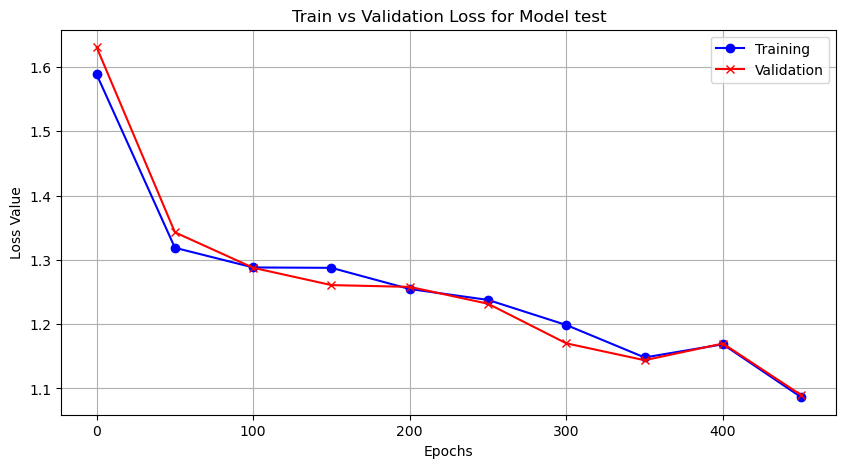

In [41]:
# train values
train_x = list(train_dict.keys())
train_y = list(train_dict.values())

# validation values
val_x = list(val_dict.keys())
val_y = list(val_dict.values())

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(train_x, train_y, marker='o', linestyle='-', color='b', label='Training')
plt.plot(val_x, val_y, marker='x', linestyle='-', color='r', label='Validation')

# Add titles and labels
title = 'Train vs Validation Loss for Model ' + model_version
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss Value')

plt.legend()

# Show the plot
plt.grid(True)
plt.show()

## Evaluate Best model- load it from checkpoint

In [32]:
val_loader = custom_loader.get_val_loader(shuffle=False)
best_model_path = "./models/model_test/best_model.pth"
label_mapping = train_loader.dataset.reverse_labels_lookup_dict

report = Evaluate(model_params, best_model_path).evaluate(val_loader, label_mapping)

c:\Users\pesta\Documents\GithubRepos\CSC871-Term-Project\GPTDecoder\eval.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.best_model_path, m

In [33]:
print(report)

              precision    recall  f1-score   support

  Irrelevant     0.5273    0.1686    0.2555       172
    Negative     0.5311    0.7068    0.6065       266
     Neutral     0.5704    0.5825    0.5764       285
    Positive     0.5533    0.5993    0.5754       277

    accuracy                         0.5490      1000
   macro avg     0.5455    0.5143    0.5034      1000
weighted avg     0.5478    0.5490    0.5289      1000



## Infer on Raw text

In [34]:
model = Evaluate(model_params, best_model_path).model

c:\Users\pesta\Documents\GithubRepos\CSC871-Term-Project\GPTDecoder\eval.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.best_model_path, m

In [35]:
def infer_on_raw_text(raw_text: str) -> str:

  encoded_inp = torch.tensor(train_loader.dataset.encode_text(input), dtype=torch.long, device=model_params.get('device')).unsqueeze(0)
  logits = model(encoded_inp)
  probs = F.softmax(logits[0], dim=-1)
  # Find the index of the largest element
  max_index = torch.argmax(probs, dim=1)

  label = label_mapping[max_index.item()]
  return label

In [40]:
text = "Good"
infer_on_raw_text(text)

'Neutral'

In [37]:
import tiktoken
tokenizer = tiktoken.get_encoding("cl100k_base") # hardcoding this for now
vocab_size = tokenizer.n_vocab  # Vocabulary size from the tokenizer
print("Vocabulary size:", vocab_size)

Vocabulary size: 100277


In [38]:
x = "123456"
print("Input text:", x[:4])

Input text: 1234
